In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

sys.path.append('/content/gdrive/My Drive/dm_image_classification')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os
import json
import re
import random
from math import sqrt

from definitions import absolute_path, IMAGES_DIR, ANNOTATIONS_DIR

In [117]:
print(os.listdir(absolute_path('input/stanford-dogs-dataset')))

['images', 'annotations']


In [0]:
with open(absolute_path(
        'input/stanford-dogs-dataset/annotations/Annotation/n02113799-standard_poodle/n02113799_489')) as f:
    reader = f.read()

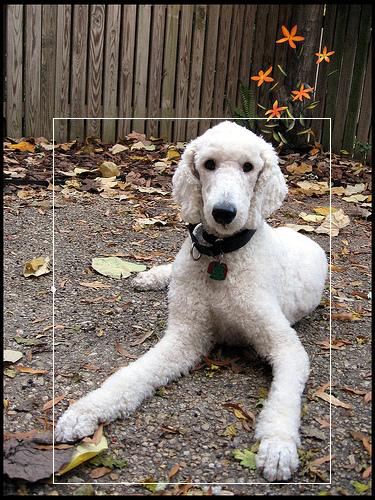

In [119]:
img = Image.open(absolute_path('input/stanford-dogs-dataset/images/Images/n02113799-standard_poodle/n02113799_489.jpg'))

xmin = int(re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)', reader)[0])
xmax = int(re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)', reader)[0])
ymin = int(re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)', reader)[0])
ymax = int(re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)', reader)[0])

origin_img = img.copy()
draw = ImageDraw.Draw(origin_img)
draw.rectangle(xy=[(xmin, ymin), (xmax, ymax)])
origin_img

In [120]:
dims = (300, 300)
old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
box = torch.FloatTensor([xmin, ymin, xmax, ymax])
new_box = box / old_dims
new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
new_box = new_box * new_dims
new_box

tensor([[ 42.4000,  70.8000, 264.0000, 289.8000]])

In [121]:
old_dims

tensor([[375., 500., 375., 500.]])

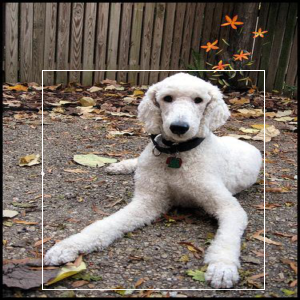

In [122]:
img = transforms.Resize(dims)(img)
draw = ImageDraw.Draw(img)
draw.rectangle(xy=[tuple(new_box.tolist()[0])[:2], tuple(new_box.tolist()[0])[2:]])
img

In [123]:
torch.FloatTensor([xmin, ymin, xmax, ymax])

tensor([ 53., 118., 330., 483.])

In [0]:
label_map = {'dog': 1}

rev_label_map = {
    1: 'dog',
    0: 'background'
}

In [0]:
all_img_folder = os.listdir(IMAGES_DIR)
all_annotation_folder = os.listdir(ANNOTATIONS_DIR)

all_img_name = []
for img_folder in all_img_folder:
    img_folder_path = '{}/{}'.format(IMAGES_DIR, img_folder)
    all_img_name += list(map(lambda x: img_folder + '/' + x, os.listdir(img_folder_path)))

all_annotation_name = []
for annotation_folder in all_annotation_folder:
    annotation_folder_path = '{}/{}'.format(ANNOTATIONS_DIR, annotation_folder)
    all_annotation_name += list(map(lambda x: annotation_folder + '/' + x, os.listdir(annotation_folder_path)))

In [135]:
len(all_img_name), all_img_name[0]

(20580, 'n02085620-Chihuahua/n02085620_10074.jpg')

In [136]:
len(all_annotation_name), all_annotation_name[0]

(20580, 'n02085620-Chihuahua/n02085620_10074')

In [0]:
class SSDDateset(Dataset):
    def __init__(self, file_folder, is_test=False, transform=None):
        self.img_folder_path = IMAGES_DIR
        self.annotation_folder_path = ANNOTATIONS_DIR
        self.file_folder = file_folder
        self.transform = transform
        self.is_test = is_test

    def __getitem__(self, idx):
        file = self.file_folder[idx]
        img_path = self.img_folder_path + '/' + file
        img = Image.open(img_path).convert('RGB')

        if not self.is_test:
            annotation_path = self.annotation_folder_path + '/' + file.split('.')[0]
            with open(annotation_path) as f:
                annotation = f.read()

            xy = self.get_xy(annotation)
            box = torch.FloatTensor(list(xy))

            new_box = self.box_resize(box, img)
            if self.transform is not None:
                img = self.transform(img)

            return img, new_box
        else:
            if self.transform is not None:
                img = self.transform(img)
            return img

    def __len__(self):
        return len(self.file_folder)

    def get_xy(self, annotation):
        xmin = int(re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)', annotation)[0])
        xmax = int(re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)', annotation)[0])
        ymin = int(re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)', annotation)[0])
        ymax = int(re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)', annotation)[0])

        return xmin, ymin, xmax, ymax

    def show_box(self):
        file = random.choice(self.file_folder)
        annotation_path = self.annotation_folder_path + '/' + file.split('.')[0]

        img_box = Image.open(self.img_folder_path + '/' + file)
        with open(annotation_path) as f:
            annotation = f.read()

        draw = ImageDraw.Draw(img_box)
        xy = self.get_xy(annotation)
        print('bbox:', xy)
        draw.rectangle(xy=[xy[:2], xy[2:]])

        return img_box

    def box_resize(self, box, img, dims=(332, 332)):
        old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
        new_box = box / old_dims
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_box = new_box * new_dims

        return new_box
    
    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        #         difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(1)
        #             difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [0]:
tsfm = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [0]:
def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).
    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.
    In the model, we are predicting bounding box coordinates in this encoded form.
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.
    They are decoded into center-size coordinates.
    This is the inverse of the function above.
    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor

def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [0]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")
        

class AuxiliaryConvolutions(nn.Module):
  def __init__(self):
      super(AuxiliaryConvolutions, self).__init__()
      self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
      self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

      self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
      self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

      self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
      self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

      self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
      self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0
      
      self.init_conv2d()
      
  def init_conv2d(self):
      """
      Initialize convolution parameters.
      """
      for c in self.children():
          if isinstance(c, nn.Conv2d):
              nn.init.xavier_uniform_(c.weight)
              nn.init.constant_(c.bias, 0.)
      
  def forward(self, conv7_feats):
      out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
      out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
      conv8_2_feats = out  # (N, 512, 10, 10)

      out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
      out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
      conv9_2_feats = out  # (N, 256, 5, 5)

      out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
      out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
      conv10_2_feats = out  # (N, 256, 3, 3)

      out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
      conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

      # Higher-level feature maps
      return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats
    
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        
        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)
        
        self.init_conv2d()
        
    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores
    
class SSD(nn.Module):
    def __init__(self, n_classes=2):
        super(SSD, self).__init__()
        self.n_classes = n_classes
        
        self.base = VGGBase().cuda()
        self.aux_convs = AuxiliaryConvolutions().cuda()
        self.pred_convs = PredictionConvolutions(n_classes).cuda()
        
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()
        
    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    
    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).cuda()  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes
    
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
#         print(n_priors)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).cuda()  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).cuda())
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).cuda())
                image_labels.append(torch.LongTensor([0]).cuda())
                image_scores.append(torch.FloatTensor([0.]).cuda())

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)
#         self.cross_entropy = nn.BCELoss()

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).cuda()  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).cuda()  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).cuda()

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).cuda()  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
EPOCH = 5
LR = 1e-3
BS = 8
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
print_feq = 100

In [162]:
model = SSD().cuda()
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)


Loaded base model.



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [0]:
train_ds = SSDDateset(all_img_name[:int(len(all_img_name)*0.8)], transform=tsfm)
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, collate_fn=train_ds.collate_fn)

valid_ds = SSDDateset(all_img_name[int(len(all_img_name)*0.8):int(len(all_img_name)*0.9)], transform=tsfm)
valid_dl = DataLoader(valid_ds, batch_size=BS, shuffle=True, collate_fn=valid_ds.collate_fn)

In [168]:
from tqdm import tqdm
import time

for epoch in range(1, EPOCH+1):
    model.train()
    train_loss = []
    for step, (img, boxes, labels) in enumerate(train_dl):
        time_1 = time.time()
        img = img.cuda()
        # box = torch.cat(box)
        boxes = [torch.tensor(box).cuda() for box in boxes]
        # label = torch.cat(label)
        labels = [torch.tensor(label).cuda() for label in labels]
        
        pred_loc, pred_sco = model(img)
        
        loss = criterion(pred_loc, pred_sco, boxes, labels)
        
         # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         losses.update(loss.item(), images.size(0))
        train_loss.append(loss.item())
        if step % print_feq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step+1, '/', len(train_dl) + 1,
                  '\ttrain loss:', '{:.4f}'.format(loss.item()),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')
    
    model.eval();
    valid_loss = []
    for step, (img, boxes, labels) in enumerate(tqdm(valid_dl)):
        img = img.cuda()
        boxes = [box.cuda() for box in boxes]
        labels = [label.cuda() for label in labels]
        pred_loc, pred_sco = model(img)
        loss = criterion(pred_loc, pred_sco, boxes, labels)
        valid_loss.append(loss.item())
        
    print('epoch:', epoch, '/', EPOCH+1,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


IndexError: ignored